In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns


import lightgbm as lgb
import joblib
from tqdm import tqdm
import os

seed = 2022
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [ ]:
df_final2 = pd.read_csv("/content/drive/MyDrive/2계정 공유드라이브/데이터/태양광 발전량 모델링 데이터.csv", encoding='utf-8')
df_final2['tm'] = pd.to_datetime(df_final2['tm'], format='%Y-%m-%d')
df_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33408 entries, 0 to 33407
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tm              33408 non-null  datetime64[ns]
 1   year            33408 non-null  int64         
 2   month           33408 non-null  int64         
 3   day             33408 non-null  int64         
 4   stnId           33408 non-null  int64         
 5   place           33408 non-null  object        
 6   plant           33408 non-null  object        
 7   amount          33408 non-null  float64       
 8   avgTa           33408 non-null  float64       
 9   avgWs           33408 non-null  float64       
 10  maxWd           33408 non-null  float64       
 11  avgRhm          33408 non-null  float64       
 12  ssDur           33408 non-null  float64       
 13  sumSsHr         33408 non-null  float64       
 14  hr1MaxIcsrHrmt  33408 non-null  float64       
 15  hr

In [ ]:
use_cols = ['tm', 'amount', 'avgTa', 'avgWs', 'avgTca', 'sumGsr', 'target']

In [ ]:
# 청주, 목포, 포항, 서울, 인천, 수원
stnIds = list(set(df_final2['stnId'].values))
stnIds

[131, 165, 138, 108, 112, 119]

In [ ]:
import datetime

def makeDataSet(stnId, plant):
  dataset=df_final2[(df_final2['stnId']==stnId) * (df_final2['plant']==plant)][use_cols]

  train_df = dataset[(dataset['tm'] <datetime.datetime(2021,1,1))]
  #train_df = train_df[train_df['target']!=0]
  train_df.set_index('tm', drop=True, inplace=True)
  #val_values = val_df.values
  train_X_values = train_df.iloc[:,:-1].values
  train_y_values = train_df.iloc[:,-1].values

  val_df = dataset[(dataset['tm']>=datetime.datetime(2021,1,1)) & (dataset['tm']<datetime.datetime(2022,1,1))]
  #val_df = val_df[val_df['target']!=0]
  val_df.set_index('tm', drop=True, inplace=True)
  #val_values = val_df.values
  val_X_values = val_df.iloc[:,:-1].values
  val_y_values = val_df.iloc[:,-1].values

  test_df = dataset[(dataset['tm']>=datetime.datetime(2022,1,1))]
  #test_df = test_df[test_df['target']!=0]     
  test_df.set_index('tm', drop=True, inplace=True)
  #test_values = test_df.values
  test_X_values = test_df.iloc[:,:-1].values
  test_y_values = test_df.iloc[:,-1].values

  testIndex = test_df.index
  return train_X_values, train_y_values, val_X_values, val_y_values, test_X_values, test_y_values, testIndex

In [ ]:
# X,y를 따로 스케일링 해야함
from sklearn import preprocessing

def X_scaling(train_values, val_values, test_values):
  scaler_X=preprocessing.MinMaxScaler(feature_range=(0,1))
  scaled_train=scaler_X.fit_transform(train_values)
  scaled_val=scaler_X.fit_transform(val_values)
  scaled_test=scaler_X.fit_transform(test_values)
  return scaler_X, scaled_train, scaled_val, scaled_test

def y_scaling(train_values, val_values, test_values):
  scaler_y=preprocessing.MinMaxScaler(feature_range=(0,1))
  scaled_train=scaler_y.fit_transform(train_values)
  scaled_val=scaler_y.fit_transform(val_values)
  scaled_test=scaler_y.fit_transform(test_values)
  return scaler_y, scaled_train, scaled_val, scaled_test

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      #agg.dropna(inplace=True)
      agg = agg.where(pd.notnull(agg), agg.mean(), axis='columns')
  return agg

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Activation

def TRAIN_model(train_X):
  model = Sequential()
  model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss=['mae', 'mse'], optimizer='RMSprop', metrics=['accuracy'])
  
  return model

In [ ]:
import numpy as np
from keras.layers import concatenate 
from numpy import sqrt 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

def makePrediction(model, test_X, test_y):

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    #test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = inv_y[:,0]

    return inv_y, inv_yhat

####1. 최대

  0%|          | 0/6 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://23e82644-f9c0-4459-a15f-ca1331562083/assets


INFO:tensorflow:Assets written to: ram://23e82644-f9c0-4459-a15f-ca1331562083/assets


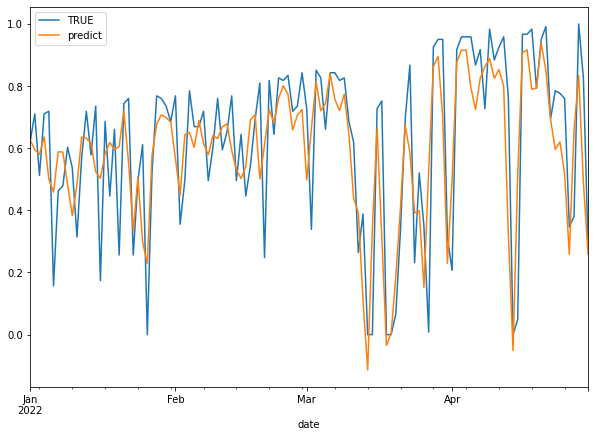

 17%|█▋        | 1/6 [00:53<04:26, 53.22s/it]WARNING:absl:Found untraced functions such as lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://555e5136-e6a7-4656-93db-3470e8cb9006/assets


INFO:tensorflow:Assets written to: ram://555e5136-e6a7-4656-93db-3470e8cb9006/assets


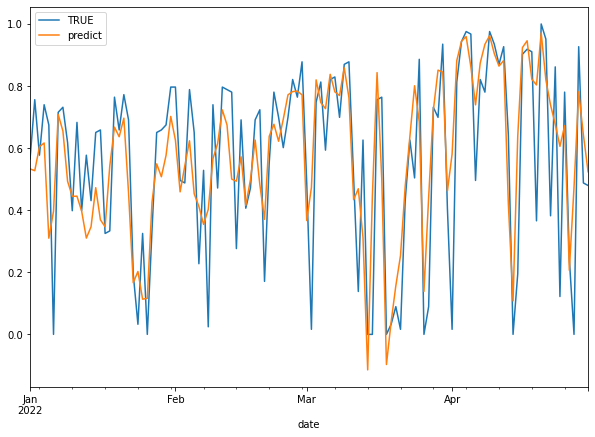

 33%|███▎      | 2/6 [01:16<02:23, 35.83s/it]WARNING:absl:Found untraced functions such as lstm_cell_2_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://b696dbea-b8ed-4ce4-a112-d163789cd6dd/assets


INFO:tensorflow:Assets written to: ram://b696dbea-b8ed-4ce4-a112-d163789cd6dd/assets


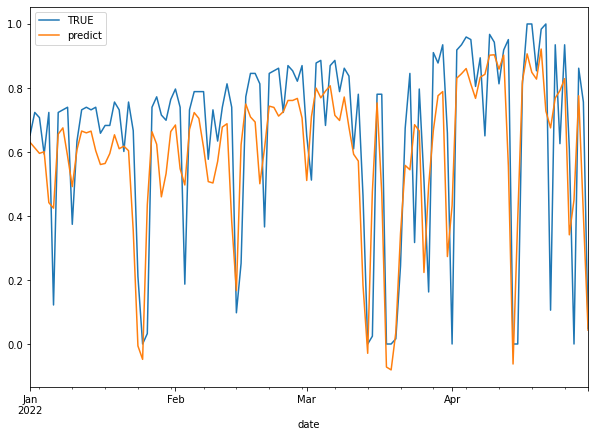

 50%|█████     | 3/6 [01:40<01:30, 30.17s/it]WARNING:absl:Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://8aa7a6b2-66fd-4d9f-aa1a-dab6e689924b/assets


INFO:tensorflow:Assets written to: ram://8aa7a6b2-66fd-4d9f-aa1a-dab6e689924b/assets


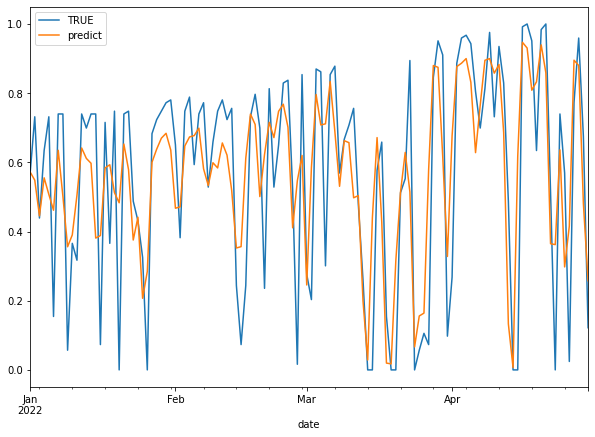

 67%|██████▋   | 4/6 [02:03<00:55, 27.51s/it]WARNING:absl:Found untraced functions such as lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://578741c9-e0a2-4269-8e2d-570463cd74f8/assets


INFO:tensorflow:Assets written to: ram://578741c9-e0a2-4269-8e2d-570463cd74f8/assets


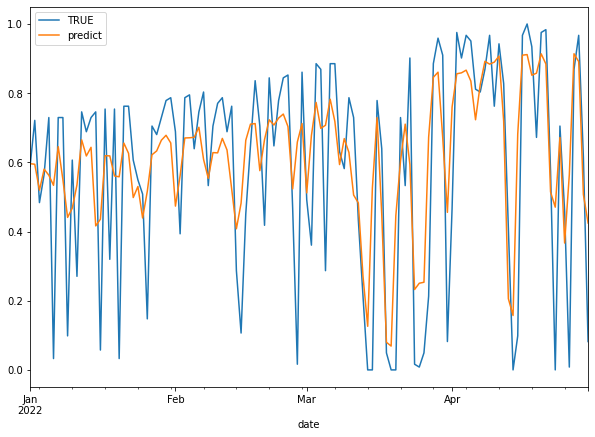

 83%|████████▎ | 5/6 [02:31<00:27, 27.69s/it]WARNING:absl:Found untraced functions such as lstm_cell_5_layer_call_fn, lstm_cell_5_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://664bebc3-b3f3-4a13-a60f-4bc080002d45/assets


INFO:tensorflow:Assets written to: ram://664bebc3-b3f3-4a13-a60f-4bc080002d45/assets


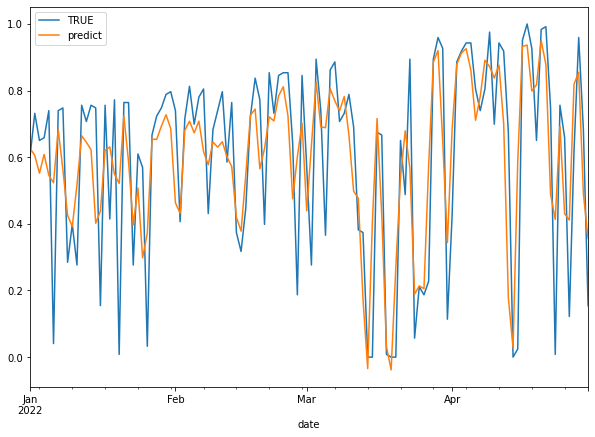

100%|██████████| 6/6 [02:55<00:00, 29.30s/it]


In [ ]:
models = {}
histories = {}
evaluate = pd.DataFrame(columns=['stnId', 'RMSE', 'R Squared'])

for stnId in tqdm(stnIds):
  train_X_values, train_y_values, val_X_values, val_y_values, test_X_values, test_y_values, testIndex = makeDataSet(stnId, "최대")

  globals()['scaler_X_{}'.format(stnId)], scaled_train_X, scaled_val_X, scaled_test_X = X_scaling(train_X_values, val_X_values, test_X_values)
  globals()['scaler_y_{}'.format(stnId)], scaled_train_y, scaled_val_y, scaled_test_y = y_scaling(train_y_values.reshape(-1,1), val_y_values.reshape(-1,1), test_y_values.reshape(-1,1))

  reframed_train_X=series_to_supervised(scaled_train_X,1,1)
  reframed_train_y=series_to_supervised(scaled_train_y,1,1)
  reframed_val_X=series_to_supervised(scaled_val_X,1,1)
  reframed_val_y=series_to_supervised(scaled_val_y,1,1)
  reframed_test_X=series_to_supervised(scaled_test_X,1,1)
  reframed_test_y=series_to_supervised(scaled_test_y,1,1)

  train_X = reframed_train_X.values
  train_y = reframed_train_y.values
  valid_X = reframed_val_X.values
  valid_y = reframed_val_y.values
  test_X = reframed_test_X.values
  test_y = reframed_test_y.values

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  
  model = TRAIN_model(train_X)
  history = model.fit(train_X, train_y, epochs=200, batch_size=128, 
        validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
  joblib.dump(model, '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MAX_scaled{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_X_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MAX_scalerX_{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_y_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MAX_scalery_{}.pkl'.format(stnId))

  inv_y, inv_yhat = makePrediction(model, test_X, test_y)
  evaluate.loc[len(evaluate)] = [stnId, sqrt(mean_squared_error(inv_y, inv_yhat)), r2_score(inv_y, inv_yhat)]

  globals()['LSTM_MAX_compare_{}'.format(stnId)] = pd.DataFrame()
  globals()['LSTM_MAX_compare_{}'.format(stnId)]['date']= testIndex
  globals()['LSTM_MAX_compare_{}'.format(stnId)]['TRUE'] = inv_y
  globals()['LSTM_MAX_compare_{}'.format(stnId)]['predict'] = inv_yhat
  #print(globals()['LSTM_MAX_compare_{}'.format(stnId)]) 
  globals()['LSTM_MAX_compare_{}'.format(stnId)].plot(x='date', figsize=(10,7))
  plt.show()

  models[stnId] = model
  histories[stnId] = history  

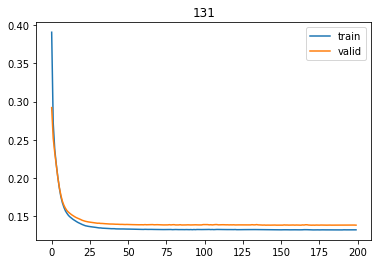

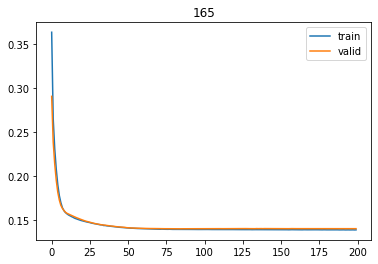

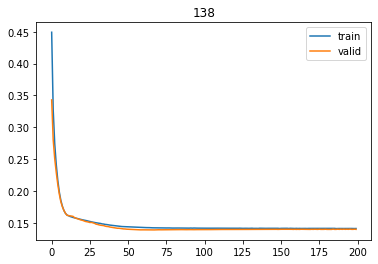

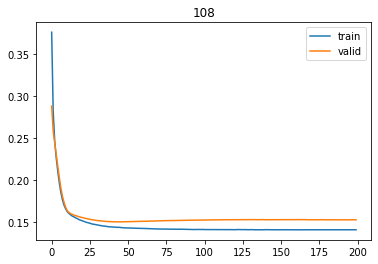

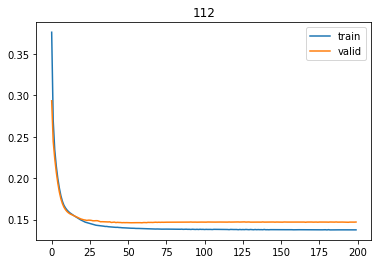

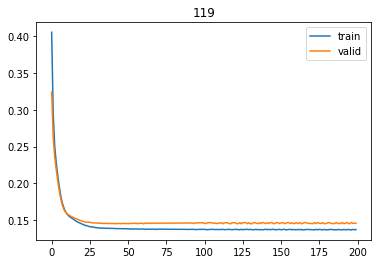

In [ ]:
for stnId in stnIds:
  plt.plot(histories[stnId].history['loss'], label='train')
  plt.plot(histories[stnId].history['val_loss'], label='valid')
  plt.title(stnId)
  plt.legend()
  plt.show()

In [ ]:
evaluate

,stnId,RMSE,R Squared
0,131.0,0.170529,0.601584
1,165.0,0.189297,0.583195
2,138.0,0.192236,0.556777
3,108.0,0.203945,0.562874
4,112.0,0.214239,0.509040
5,119.0,0.189392,0.576367


In [ ]:
for stnId in stnIds:
  print('LSTM_MAX_compare_{}'.format(stnId))
  globals()['LSTM_MAX_compare_{}'.format(stnId)]['predict'] = pd.Series([0.0 if i < 0 else i for i in globals()['LSTM_MAX_compare_{}'.format(stnId)]['predict']])
  print(globals()['LSTM_MAX_compare_{}'.format(stnId)])

LSTM_MAX_compare_131
          date      TRUE   predict
0   2022-01-01  0.620251  0.627113
1   2022-01-02  0.710744  0.594957
2   2022-01-03  0.512397  0.580079
3   2022-01-04  0.710744  0.636475
4   2022-01-05  0.719008  0.500449
..         ...       ...       ...
115 2022-04-26  0.347107  0.258745
116 2022-04-27  0.380165  0.657491
117 2022-04-28  1.000000  0.833791
118 2022-04-29  0.826446  0.491013
119 2022-04-30  0.289256  0.258180

[120 rows x 3 columns]
LSTM_MAX_compare_165
          date      TRUE   predict
0   2022-01-01  0.565621  0.533075
1   2022-01-02  0.756098  0.527349
2   2022-01-03  0.577236  0.604701
3   2022-01-04  0.739837  0.616597
4   2022-01-05  0.674797  0.309865
..         ...       ...       ...
115 2022-04-26  0.243902  0.206591
116 2022-04-27  0.000000  0.473261
117 2022-04-28  0.926829  0.781578
118 2022-04-29  0.487805  0.642955
119 2022-04-30  0.479675  0.523868

[120 rows x 3 columns]
LSTM_MAX_compare_138
          date      TRUE   predict
0   2022-01-01

####2. 평균

  0%|          | 0/6 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as lstm_cell_6_layer_call_fn, lstm_cell_6_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://f9d83973-48ed-45c0-9ab0-62439a3b3df3/assets


INFO:tensorflow:Assets written to: ram://f9d83973-48ed-45c0-9ab0-62439a3b3df3/assets


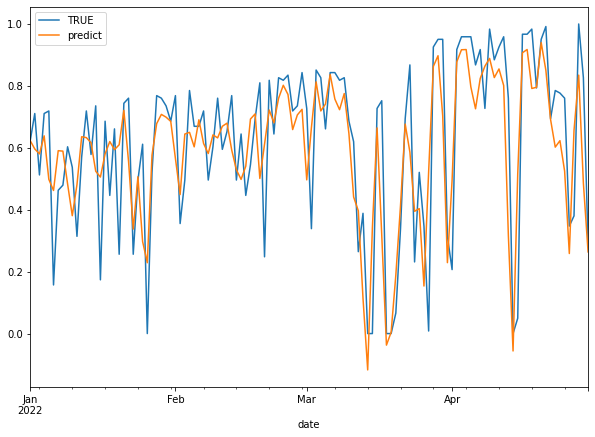

 17%|█▋        | 1/6 [00:28<02:21, 28.21s/it]WARNING:absl:Found untraced functions such as lstm_cell_7_layer_call_fn, lstm_cell_7_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://609bc8bc-9a02-4066-8b40-eea51895d18f/assets


INFO:tensorflow:Assets written to: ram://609bc8bc-9a02-4066-8b40-eea51895d18f/assets


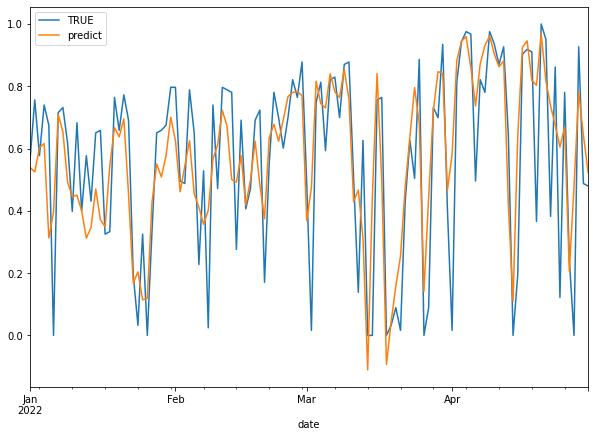

 33%|███▎      | 2/6 [00:52<01:42, 25.65s/it]WARNING:absl:Found untraced functions such as lstm_cell_8_layer_call_fn, lstm_cell_8_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://6f9c2640-2198-4ad9-a66c-d093430e237e/assets


INFO:tensorflow:Assets written to: ram://6f9c2640-2198-4ad9-a66c-d093430e237e/assets


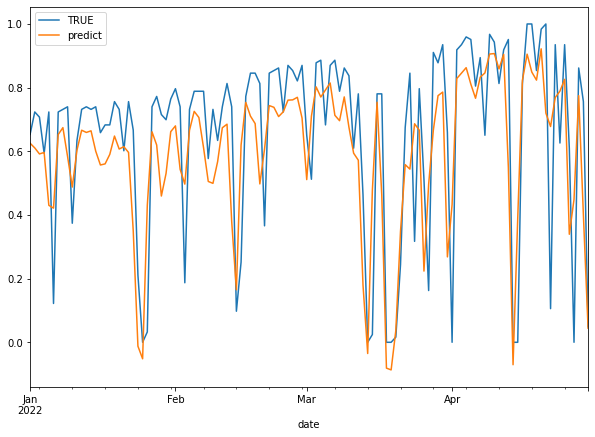

 50%|█████     | 3/6 [01:19<01:19, 26.57s/it]WARNING:absl:Found untraced functions such as lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://1c673b7c-9396-456c-98c4-b906278c1c30/assets


INFO:tensorflow:Assets written to: ram://1c673b7c-9396-456c-98c4-b906278c1c30/assets


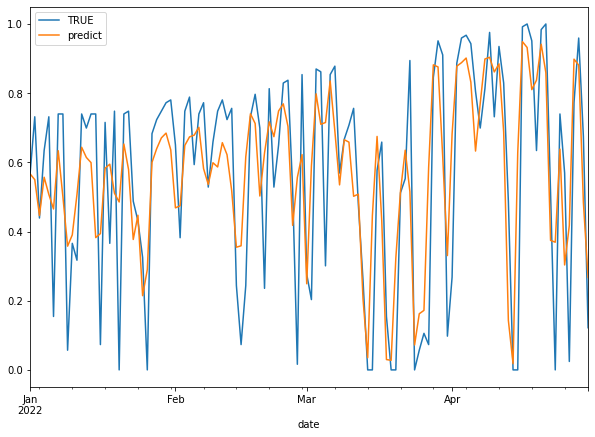

 67%|██████▋   | 4/6 [01:47<00:53, 26.99s/it]WARNING:absl:Found untraced functions such as lstm_cell_10_layer_call_fn, lstm_cell_10_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://884c5b4e-aaa1-42e0-89d1-a2648c5fd94f/assets


INFO:tensorflow:Assets written to: ram://884c5b4e-aaa1-42e0-89d1-a2648c5fd94f/assets


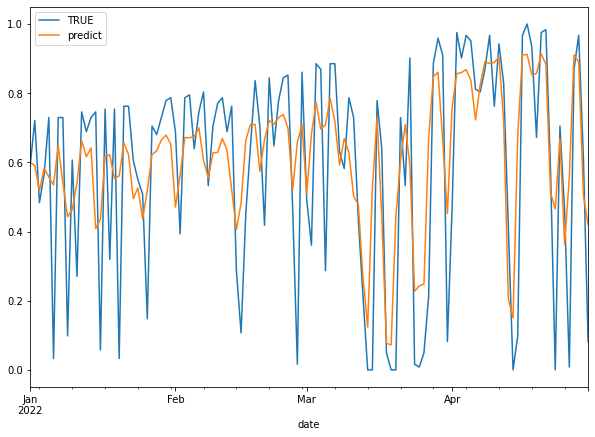

 83%|████████▎ | 5/6 [02:10<00:25, 25.67s/it]WARNING:absl:Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://1656555d-0a0f-4d0b-a1c8-5f263a6dda46/assets


INFO:tensorflow:Assets written to: ram://1656555d-0a0f-4d0b-a1c8-5f263a6dda46/assets


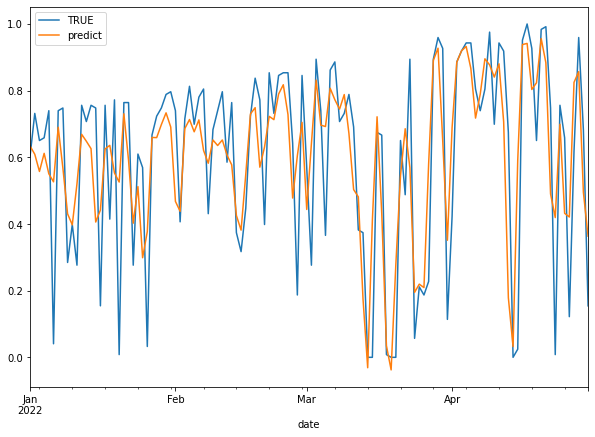

100%|██████████| 6/6 [02:37<00:00, 26.33s/it]


In [ ]:
models = {}
histories = {}
evaluate = pd.DataFrame(columns=['stnId', 'RMSE', 'R Squared'])

for stnId in tqdm(stnIds):
  train_X_values, train_y_values, val_X_values, val_y_values, test_X_values, test_y_values, testIndex = makeDataSet(stnId, "평균")

  globals()['scaler_X_{}'.format(stnId)], scaled_train_X, scaled_val_X, scaled_test_X = X_scaling(train_X_values, val_X_values, test_X_values)
  globals()['scaler_y_{}'.format(stnId)], scaled_train_y, scaled_val_y, scaled_test_y = y_scaling(train_y_values.reshape(-1,1), val_y_values.reshape(-1,1), test_y_values.reshape(-1,1))

  reframed_train_X=series_to_supervised(scaled_train_X,1,1)
  reframed_train_y=series_to_supervised(scaled_train_y,1,1)
  reframed_val_X=series_to_supervised(scaled_val_X,1,1)
  reframed_val_y=series_to_supervised(scaled_val_y,1,1)
  reframed_test_X=series_to_supervised(scaled_test_X,1,1)
  reframed_test_y=series_to_supervised(scaled_test_y,1,1)

  train_X = reframed_train_X.values
  train_y = reframed_train_y.values
  valid_X = reframed_val_X.values
  valid_y = reframed_val_y.values
  test_X = reframed_test_X.values
  test_y = reframed_test_y.values

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  
  model = TRAIN_model(train_X)
  history = model.fit(train_X, train_y, epochs=200, batch_size=128, 
        validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
  joblib.dump(model, '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_AVG_scaled{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_X_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_AVG_scalerX_{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_y_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_AVG_scalery_{}.pkl'.format(stnId))

  inv_y, inv_yhat = makePrediction(model, test_X, test_y)
  evaluate.loc[len(evaluate)] = [stnId, sqrt(mean_squared_error(inv_y, inv_yhat)), r2_score(inv_y, inv_yhat)]

  globals()['LSTM_AVG_compare_{}'.format(stnId)] = pd.DataFrame()
  globals()['LSTM_AVG_compare_{}'.format(stnId)]['date']= testIndex
  globals()['LSTM_AVG_compare_{}'.format(stnId)]['TRUE'] = inv_y
  globals()['LSTM_AVG_compare_{}'.format(stnId)]['predict'] = inv_yhat
  #print(globals()['LSTM_AVG_compare_{}'.format(stnId)]) 
  globals()['LSTM_AVG_compare_{}'.format(stnId)].plot(x='date', figsize=(10,7))
  plt.show()

  models[stnId] = model
  histories[stnId] = history  

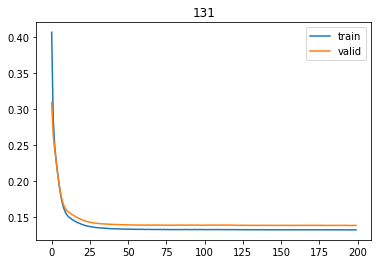

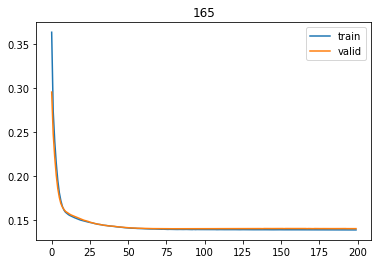

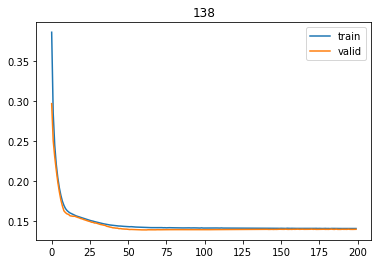

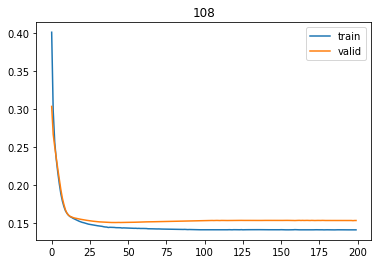

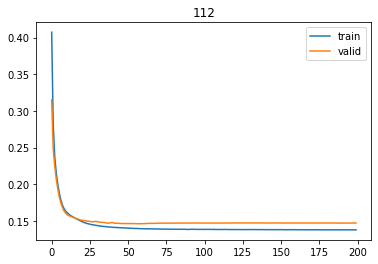

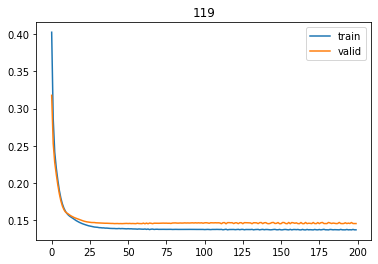

In [ ]:
for stnId in stnIds:
  plt.plot(histories[stnId].history['loss'], label='train')
  plt.plot(histories[stnId].history['val_loss'], label='valid')
  plt.title(stnId)
  plt.legend()
  plt.show()

In [ ]:
evaluate

,stnId,RMSE,R Squared
0,131.0,0.170647,0.601031
1,165.0,0.189209,0.583583
2,138.0,0.193724,0.549888
3,108.0,0.205104,0.557892
4,112.0,0.214395,0.508325
5,119.0,0.189865,0.574246


In [ ]:
for stnId in stnIds:
  print('LSTM_AVG_compare_{}'.format(stnId))
  globals()['LSTM_AVG_compare_{}'.format(stnId)]['predict'] = pd.Series([0.0 if i < 0 else i for i in globals()['LSTM_AVG_compare_{}'.format(stnId)]['predict']])
  print(globals()['LSTM_AVG_compare_{}'.format(stnId)])

LSTM_AVG_compare_131
          date      TRUE   predict
0   2022-01-01  0.620251  0.623969
1   2022-01-02  0.710744  0.596328
2   2022-01-03  0.512397  0.580268
3   2022-01-04  0.710744  0.638677
4   2022-01-05  0.719008  0.498168
..         ...       ...       ...
115 2022-04-26  0.347107  0.258569
116 2022-04-27  0.380165  0.656013
117 2022-04-28  1.000000  0.834797
118 2022-04-29  0.826446  0.485617
119 2022-04-30  0.289256  0.263735

[120 rows x 3 columns]
LSTM_AVG_compare_165
          date      TRUE   predict
0   2022-01-01  0.565621  0.539444
1   2022-01-02  0.756098  0.524749
2   2022-01-03  0.577236  0.603119
3   2022-01-04  0.739837  0.616304
4   2022-01-05  0.674797  0.313267
..         ...       ...       ...
115 2022-04-26  0.243902  0.205569
116 2022-04-27  0.000000  0.476497
117 2022-04-28  0.926829  0.781082
118 2022-04-29  0.487805  0.643614
119 2022-04-30  0.479675  0.523885

[120 rows x 3 columns]
LSTM_AVG_compare_138
          date      TRUE   predict
0   2022-01-01

####3. 최소

  0%|          | 0/6 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as lstm_cell_12_layer_call_fn, lstm_cell_12_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://558e7773-a723-4852-ad0a-dd420688fcdf/assets


INFO:tensorflow:Assets written to: ram://558e7773-a723-4852-ad0a-dd420688fcdf/assets


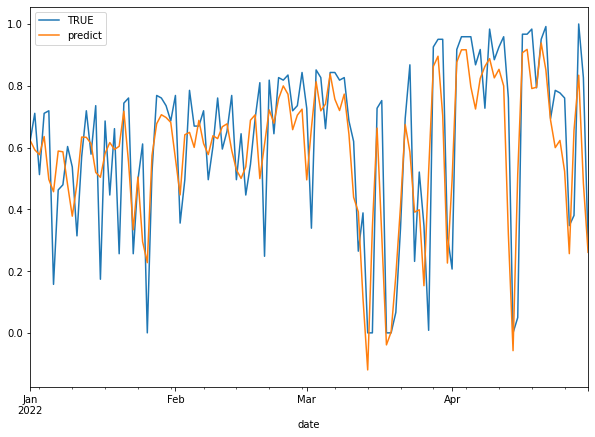

 17%|█▋        | 1/6 [00:29<02:25, 29.02s/it]WARNING:absl:Found untraced functions such as lstm_cell_13_layer_call_fn, lstm_cell_13_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://a13cf9ac-b84c-44af-86f4-3f5599509509/assets


INFO:tensorflow:Assets written to: ram://a13cf9ac-b84c-44af-86f4-3f5599509509/assets


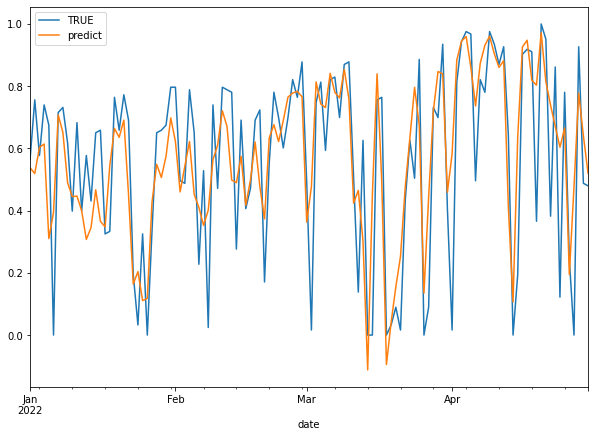

 33%|███▎      | 2/6 [00:56<01:53, 28.25s/it]WARNING:absl:Found untraced functions such as lstm_cell_14_layer_call_fn, lstm_cell_14_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://b6a07471-ac43-4850-b71e-a5509dcd407f/assets


INFO:tensorflow:Assets written to: ram://b6a07471-ac43-4850-b71e-a5509dcd407f/assets


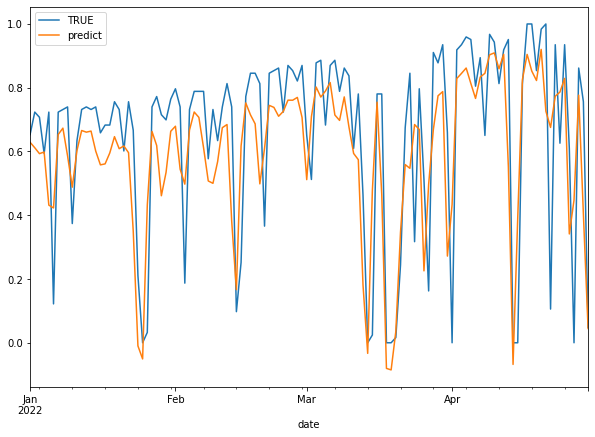

 50%|█████     | 3/6 [01:19<01:17, 25.97s/it]WARNING:absl:Found untraced functions such as lstm_cell_15_layer_call_fn, lstm_cell_15_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://09e0a297-5bb0-4c3f-a774-921bb68c3206/assets


INFO:tensorflow:Assets written to: ram://09e0a297-5bb0-4c3f-a774-921bb68c3206/assets


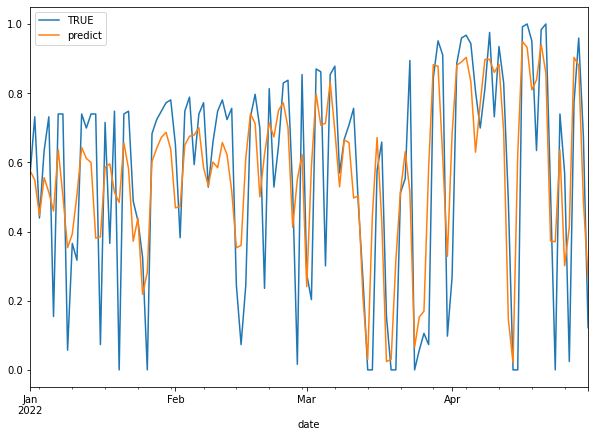

 67%|██████▋   | 4/6 [01:44<00:51, 25.53s/it]WARNING:absl:Found untraced functions such as lstm_cell_16_layer_call_fn, lstm_cell_16_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://353f69d7-e191-4347-bd8d-c49a59d883f4/assets


INFO:tensorflow:Assets written to: ram://353f69d7-e191-4347-bd8d-c49a59d883f4/assets


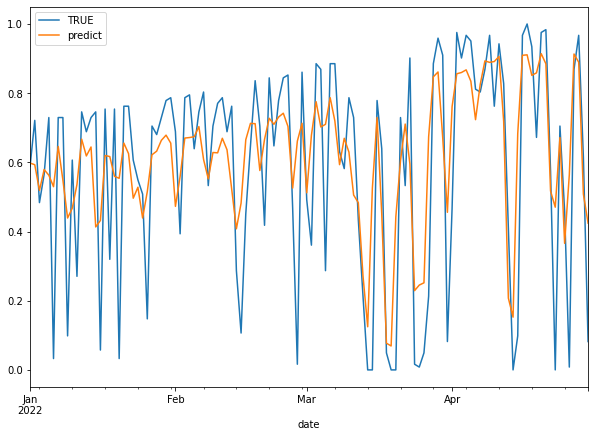

 83%|████████▎ | 5/6 [02:08<00:24, 24.79s/it]WARNING:absl:Found untraced functions such as lstm_cell_17_layer_call_fn, lstm_cell_17_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://7284b171-3096-4c2a-a4ec-d7cc33316a17/assets


INFO:tensorflow:Assets written to: ram://7284b171-3096-4c2a-a4ec-d7cc33316a17/assets


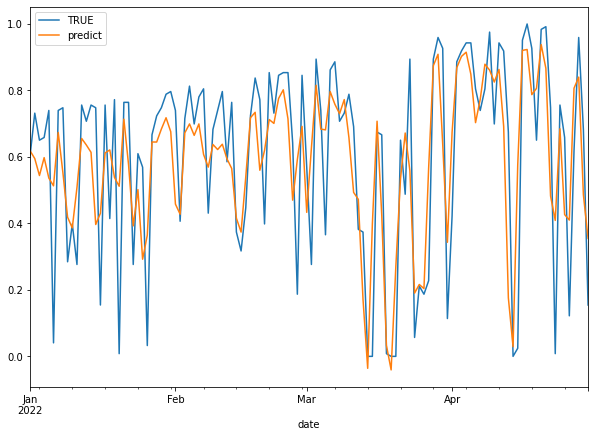

100%|██████████| 6/6 [02:31<00:00, 25.28s/it]


In [ ]:
models = {}
histories = {}
evaluate = pd.DataFrame(columns=['stnId', 'RMSE', 'R Squared'])

for stnId in tqdm(stnIds):
  train_X_values, train_y_values, val_X_values, val_y_values, test_X_values, test_y_values, testIndex = makeDataSet(stnId, "최소")

  globals()['scaler_X_{}'.format(stnId)], scaled_train_X, scaled_val_X, scaled_test_X = X_scaling(train_X_values, val_X_values, test_X_values)
  globals()['scaler_y_{}'.format(stnId)], scaled_train_y, scaled_val_y, scaled_test_y = y_scaling(train_y_values.reshape(-1,1), val_y_values.reshape(-1,1), test_y_values.reshape(-1,1))

  reframed_train_X=series_to_supervised(scaled_train_X,1,1)
  reframed_train_y=series_to_supervised(scaled_train_y,1,1)
  reframed_val_X=series_to_supervised(scaled_val_X,1,1)
  reframed_val_y=series_to_supervised(scaled_val_y,1,1)
  reframed_test_X=series_to_supervised(scaled_test_X,1,1)
  reframed_test_y=series_to_supervised(scaled_test_y,1,1)

  train_X = reframed_train_X.values
  train_y = reframed_train_y.values
  valid_X = reframed_val_X.values
  valid_y = reframed_val_y.values
  test_X = reframed_test_X.values
  test_y = reframed_test_y.values

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  
  model = TRAIN_model(train_X)
  history = model.fit(train_X, train_y, epochs=200, batch_size=128, 
        validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
  joblib.dump(model, '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MIN_scaled{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_X_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MIN_scalerX_{}.pkl'.format(stnId))
  joblib.dump(globals()['scaler_y_{}'.format(stnId)], '/content/drive/MyDrive/2계정 공유드라이브/모델/'+'LSTM_MIN_scalery_{}.pkl'.format(stnId))

  inv_y, inv_yhat = makePrediction(model, test_X, test_y)
  evaluate.loc[len(evaluate)] = [stnId, sqrt(mean_squared_error(inv_y, inv_yhat)), r2_score(inv_y, inv_yhat)]

  globals()['LSTM_MIN_compare_{}'.format(stnId)] = pd.DataFrame()
  globals()['LSTM_MIN_compare_{}'.format(stnId)]['date']= testIndex
  globals()['LSTM_MIN_compare_{}'.format(stnId)]['TRUE'] = inv_y
  globals()['LSTM_MIN_compare_{}'.format(stnId)]['predict'] = inv_yhat
  #print(globals()['LSTM_MIN_compare_{}'.format(stnId)]) 
  globals()['LSTM_MIN_compare_{}'.format(stnId)].plot(x='date', figsize=(10,7))
  plt.show()

  models[stnId] = model
  histories[stnId] = history  

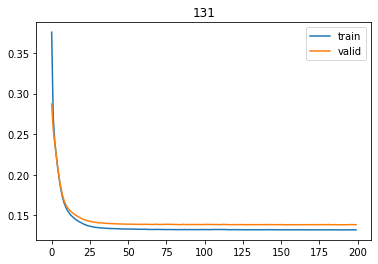

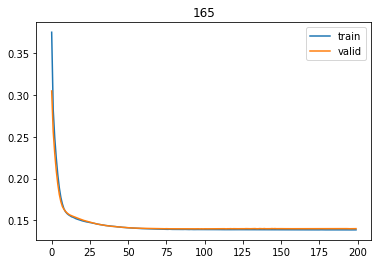

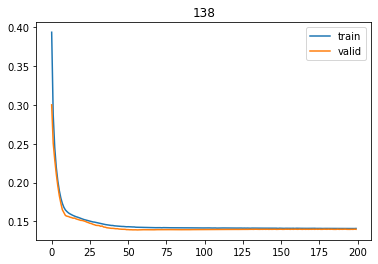

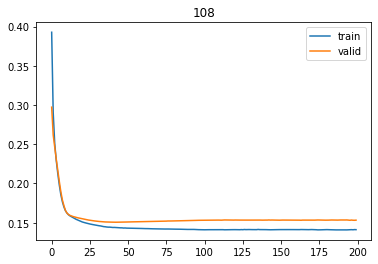

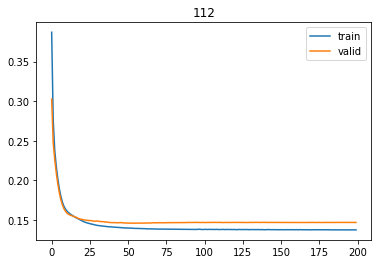

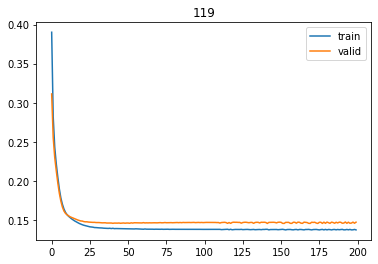

In [ ]:
for stnId in stnIds:
  plt.plot(histories[stnId].history['loss'], label='train')
  plt.plot(histories[stnId].history['val_loss'], label='valid')
  plt.title(stnId)
  plt.legend()
  plt.show()

In [ ]:
evaluate

,stnId,RMSE,R Squared
0,131.0,0.170611,0.601198
1,165.0,0.190423,0.578222
2,138.0,0.192806,0.554147
3,108.0,0.204098,0.562220
4,112.0,0.213891,0.510633
5,119.0,0.190023,0.573540


In [ ]:
for stnId in stnIds:
  print('LSTM_MIN_compare_{}'.format(stnId))
  globals()['LSTM_MIN_compare_{}'.format(stnId)]['predict'] = pd.Series([0.0 if i < 0 else i for i in globals()['LSTM_MIN_compare_{}'.format(stnId)]['predict']])
  print(globals()['LSTM_MIN_compare_{}'.format(stnId)])

LSTM_MIN_compare_131
          date      TRUE   predict
0   2022-01-01  0.620251  0.623750
1   2022-01-02  0.710744  0.592703
2   2022-01-03  0.512397  0.576806
3   2022-01-04  0.710744  0.635656
4   2022-01-05  0.719008  0.496732
..         ...       ...       ...
115 2022-04-26  0.347107  0.256448
116 2022-04-27  0.380165  0.655777
117 2022-04-28  1.000000  0.834167
118 2022-04-29  0.826446  0.484584
119 2022-04-30  0.289256  0.260703

[120 rows x 3 columns]
LSTM_MIN_compare_165
          date      TRUE   predict
0   2022-01-01  0.565621  0.537401
1   2022-01-02  0.756098  0.519465
2   2022-01-03  0.577236  0.603212
3   2022-01-04  0.739837  0.614262
4   2022-01-05  0.674797  0.310213
..         ...       ...       ...
115 2022-04-26  0.243902  0.194614
116 2022-04-27  0.000000  0.477699
117 2022-04-28  0.926829  0.778210
118 2022-04-29  0.487805  0.640720
119 2022-04-30  0.479675  0.519399

[120 rows x 3 columns]
LSTM_MIN_compare_138
          date      TRUE   predict
0   2022-01-01

# 모델 시연

In [ ]:
!pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 9.4 MB/s 


In [ ]:
!pip install siphon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.1 MB/s 


In [ ]:
import pvlib
from pvlib import forecast
import pandas as pd
import datetime

latlong =   {'청주' : [36.62157, 127.51468],
        '목포' : [34.81654, 126.39937],
        '포항' : [35.95761, 129.37818],
        '서울' : [37.51198, 126.82965],
        '인천' : [37.43454, 126.62459],
        '수원' : [37.28817, 127.03348]           
    }

regions = {'목포': 165, '서울': 108, '수원': 119, '인천': 112, '청주': 131, '포항': 138}
area = "청주"   #입력받는 지역
size = "1320"   #입력받는 설비용량
stnId = regions[area]

# 지역에 따른 위/경도 구하기
latitude, longtitude, tz = latlong[area][0] , latlong[area][1], 'Asia/Seoul'
start = pd.Timestamp(datetime.date.today(), tz='Asia/Seoul')
end = start + pd.Timedelta(days=15)

# get GFS forecast
GFSmodel = forecast.GFS()
GFSfcst = GFSmodel.get_data(latitude, longtitude,
                            start=start,
                            end=end)

GFSfcst = GFSfcst.resample('1h').interpolate()
GFSfcst = GFSmodel.process_data(GFSfcst)

fcstWeather=GFSfcst[['temp_air', 'wind_speed', 'dhi', 'mid_clouds']]

# 합계 일사량의 경우 MJ/m2(일), dhi의 경우 W/m2(초), W는 J/s로 순간값
# [DHI * (60*60) * 10^(-6)] = 1시간의 일사량(gsr)
# gsr 24시간동안의 합 = 합계 일사량
avgTa = []    #평균 기온
avgWs = []    #평균 풍속
avgTca = []   #평균 전운량 -> GFSfcst는 0~100, train은 0~10이므로 10으로 나눠서 계산
sumGsr = []   #합계 일사량

#'tm', 'amount', 'avgTa', 'avgWs', 'avgTca', 'sumGsr'
X = pd.DataFrame(columns=['tm', 'amount', 'avgTa', 'avgWs', 'avgTca', 'sumGsr'])
fcstWeather['gsr'] = fcstWeather['dhi']*(60*60)*1e-6
for i in range(len(fcstWeather)//24):
    avgTa.append(sum(fcstWeather['temp_air'][i*24:(i+1)*24])/24)
    avgWs.append(sum(fcstWeather['wind_speed'][i*24:(i+1)*24])/24)
    avgTca.append(sum(fcstWeather['mid_clouds'][i*24:(i+1)*24]/10)/24)
    sumGsr.append(sum(fcstWeather['gsr'][i*24:(i+1)*24]))
    # gsr = sum(fcstWeather['dhi'][i*24:(i+1)*24])/24

X['tm'] = pd.date_range(datetime.date.today(), periods=15).tolist()
X['amount'] = size
X['avgTa'] = avgTa
X['avgWs'] = avgWs
X['avgTca'] = avgTca
X['sumGsr'] = sumGsr
X.set_index('tm', drop=True, inplace=True)

testmodel = joblib.load("/content/drive/MyDrive/2계정 공유드라이브/모델/LSTM_AVG_scaled{}.pkl".format(stnId)) #지역에 맞는 모델 가져오기, 경로수정
scalerX = joblib.load("/content/drive/MyDrive/2계정 공유드라이브/모델/LSTM_AVG_scalerX_{}.pkl".format(stnId))   #지역에 맞는 scalerX 가져오기, 경로수정
scalery = joblib.load("/content/drive/MyDrive/2계정 공유드라이브/모델/LSTM_AVG_scalery_{}.pkl".format(stnId))   #지역에 맞는 scalery 가져오기, 경로수정

X_values = X.values
scaled_X = scalerX.fit_transform(X_values)
reframed_X = series_to_supervised(scaled_X,1,1)
test_X = reframed_X.values
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# test
ytest = testmodel.predict(test_X)
ytest_rescale = scalery.inverse_transform(ytest)
ytest_rescale

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: pvlibDeprecationWarning: The GFS class was deprecated in pvlib 0.9.1 and will be removed in a future release. For details, see https://pvlib-python.readthedocs.io/en/stable/user_guide/forecasts.html
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([[858.42584],
       [886.3615 ],
       [739.26013],
       [736.3557 ],
       [855.50165],
       [686.66187],
       [664.43036],
       [572.3234 ],
       [560.1724 ],
       [902.48895],
       [859.4268 ],
       [841.8617 ],
       [958.43555],
       [815.22217],
       [545.50226]], dtype=float32)